# Imports

In [1]:
from imblearn.over_sampling import SMOTE
import json
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.amp import autocast, GradScaler
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
DATA_DIR = "content/ham10k"
METADATA = "content/HAM10000_metadata.csv"
IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 25
LR = 3e-4
SEED = 123
MAX_SAMPLES_PER_CLASS = 700
SAVE_DIR = "content/model"

In [3]:
# Reproducibility

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False


# For DataLoader workers
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed(worker_seed)


# Generator for DataLoader
g = torch.Generator(device="cpu")
g.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

set_seed(SEED)
print(f"Running on {DEVICE}")

Running on cuda


In [4]:
# Load metadata
meta_df = pd.read_csv(METADATA)

meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Verify image files exist
expected_images = set(meta_df['image_id'] + '.jpg')
actual_images = set(os.listdir(DATA_DIR))
missing_images = expected_images - actual_images
print(f"Missing images: {len(missing_images)}")

Missing images: 0


In [6]:
# Replace missing values in metadata - about 200 rows
# Age --> Mean value
mean_age = meta_df['age'].mean()
meta_df['age'] = meta_df['age'].fillna(mean_age).astype(int)

# Sex --> Random male or female
unknown = meta_df[meta_df['sex'] == 'unknown'].index
shuffled = np.random.permutation(unknown)
half = len(shuffled) // 2

male_idx = shuffled[:half]
female_idx = shuffled[half:]
meta_df.loc[male_idx, 'sex'] = 'male'
meta_df.loc[female_idx, 'sex'] = 'female'

# Localization --> Random label given distribution
known = meta_df[meta_df['localization'] != 'unknown']['localization'].value_counts(normalize=True)
unknown = meta_df[meta_df['localization'] == 'unknown'].index
replacements = np.random.choice(known.index, size=len(unknown), p=known.values)
meta_df.loc[unknown, 'localization'] = replacements

In [7]:
# Get a list of unique classes
class_labels = sorted(meta_df['dx'].unique())

# Create a mapping from class abbreviation to a more descriptive name
lesion_type_mapping = {
    'nv': 'lesio',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### Display some images to be used in report

Wrapped in if statement instead of commented out. Change "run" to True to see the plot created

In [8]:
# Plot the class distribution
run = False

if run:
    # Reset matplotlib style
    rc_file_defaults()

    c = [plt.cm.Paired(i) for i in range(7)]

    plt.figure(figsize=(8, 6))
    plot = sns.barplot(meta_df['dx'].value_counts(), palette=c)
    plt.title('Class Distribution')
    plt.xlabel('Diagnosis Category (class)')
    plt.ylabel('Number of images')
    plt.xticks(rotation=45, ha='right')

    for patch in plot.patches:
            plot.annotate(format(patch.get_height(), '.0f'),
            xy=(patch.get_x() + patch.get_width() / 2., patch.get_height()),
            ha='center', va='center', xytext=(0, 6), fontsize=8.5, textcoords='offset points')

    plt.tight_layout()
    # Save image
    #plt.savefig(("content/images/ham10k_class_distribution.png"), bbox_inches='tight')

    plt.show()

In [9]:
# Generate five sample images for each class
run = False

if run:
    num_samples_per_class = 5
    sampled_images = {}

    for label in class_labels:
        class_df = meta_df[meta_df['dx'] == label]
        if len(class_df) >= num_samples_per_class:
            sampled_files = class_df['image_id'].sample(num_samples_per_class)
            sampled_images[label] = list(sampled_files)

    # Display the images
    fig, axes = plt.subplots(len(class_labels), num_samples_per_class, figsize=(15, 3 * len(class_labels)))

    for i, label in enumerate(class_labels):
        if label in sampled_images:
            descriptive_label = lesion_type_mapping.get(label, label)
            for j, image_id in enumerate(sampled_images[label]):
                image_path = os.path.join(DATA_DIR, f'{image_id}.jpg')
                try:
                    img = Image.open(image_path)
                    resized_img = img.resize((64, 64))
                    axes[i, j].imshow(img)
                    axes[i, j].axis('off')
                    if j == 0:  # Set the label only for the first image in each row
                        axes[i, j].set_title(lesion_type_mapping.get(label, label), fontsize=16)
                except FileNotFoundError:
                    print(f"Error: Image file not found at {image_path}")

    plt.tight_layout()
    # Save image
    plt.savefig("content/images/ham10k_5samples.png", bbox_inches='tight')

    plt.show()

### Transform Metadata Values

In [10]:
# Age: standardize
mm_scaler = MinMaxScaler()
transformed_meta_df = pd.DataFrame(mm_scaler.fit_transform(meta_df[['age']]), columns=['age_scaled'])

# Sex: binary encode
transformed_meta_df['sex_binary'] = meta_df['sex'].map({'male': 0, 'female': 1})

# Location: get dummies
location_encoded = pd.get_dummies(meta_df['localization'], prefix='loc', dtype=float)
transformed_meta_df = transformed_meta_df.join(location_encoded)

meta_df = meta_df.join(transformed_meta_df)

# Keep separate transformed df for later use
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_scaled,sex_binary,loc_abdomen,...,loc_ear,loc_face,loc_foot,loc_genital,loc_hand,loc_lower extremity,loc_neck,loc_scalp,loc_trunk,loc_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,0.941176,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,0.941176,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,0.941176,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,0.941176,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,0.882353,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression on Metadata w/o Oversampling

In [11]:
# Separate features and target
X = transformed_meta_df
y = meta_df['dx']

encoder = LabelEncoder()

# Fit and transform the target labels
y_encoded = encoder.fit_transform(y)


              precision    recall  f1-score   support

       akiec       0.13      0.42      0.19        65
         bcc       0.13      0.35      0.19       103
         bkl       0.40      0.14      0.21       220
          df       0.04      0.78      0.07        23
         mel       0.15      0.09      0.11       223
          nv       0.90      0.23      0.36      1341
        vasc       0.02      0.29      0.03        28

    accuracy                           0.22      2003
   macro avg       0.25      0.33      0.17      2003
weighted avg       0.67      0.22      0.30      2003



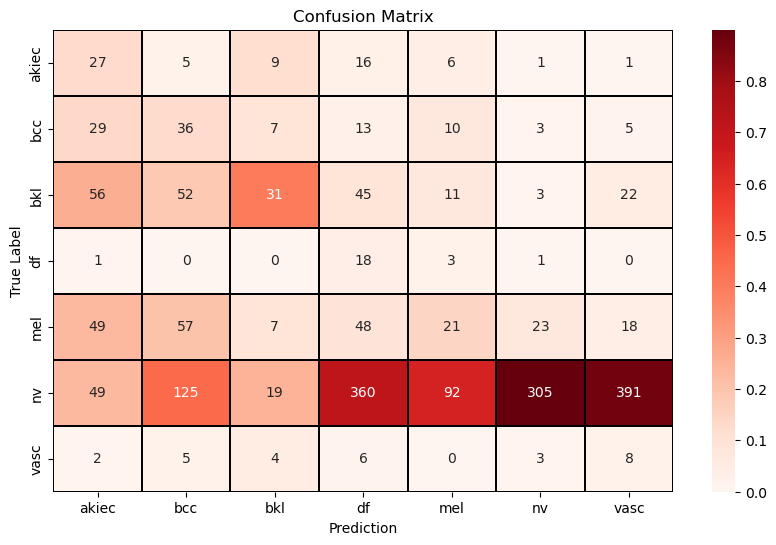

In [44]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded)

# Initialize logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')

# Train model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=0, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_normalized, annot=cm, fmt=".0f", linewidths=.2, linecolor="black", xticklabels=class_labels,
                yticklabels=class_labels, cmap="Reds")
ax.set_xlabel("Prediction")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix")
plt.show()

### XGBoost Classifier on Metadata w/o Oversampling

              precision    recall  f1-score   support

       akiec       0.38      0.12      0.19        65
         bcc       0.25      0.08      0.12       103
         bkl       0.41      0.35      0.38       220
          df       0.00      0.00      0.00        23
         mel       0.32      0.16      0.21       223
          nv       0.77      0.94      0.85      1341
        vasc       0.33      0.04      0.06        28

    accuracy                           0.70      2003
   macro avg       0.35      0.24      0.26      2003
weighted avg       0.62      0.70      0.65      2003



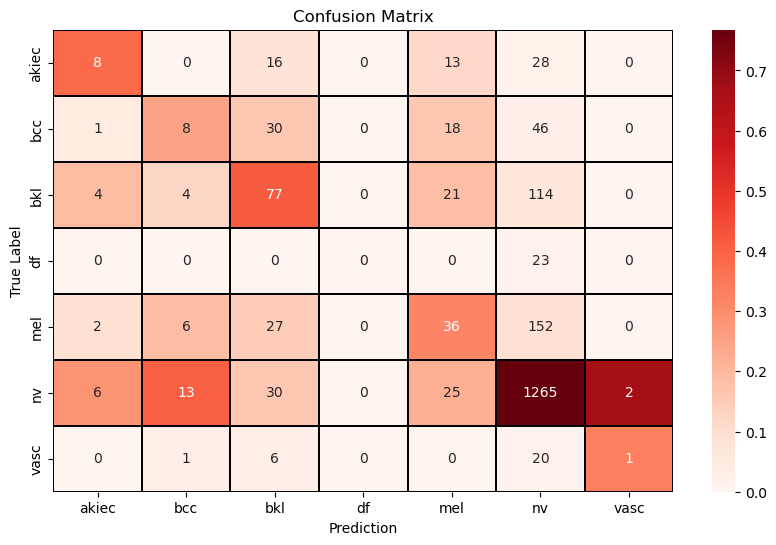

In [46]:
# Initialize XGB model
clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=7,
)

# Train model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
col_sum = cm.sum(axis=0, keepdims=True)
col_sum[col_sum == 0] = 1
cm_normalized = cm.astype('float') / col_sum
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_normalized, annot=cm, fmt=".0f", linewidths=.2, linecolor="black", xticklabels=class_labels,
                yticklabels=class_labels, cmap="Reds")
ax.set_xlabel("Prediction")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix")
plt.show()

### XGBoost Classifier on Metadata w/ Oversampling

              precision    recall  f1-score   support

       akiec       0.12      0.45      0.19        65
         bcc       0.17      0.36      0.23       103
         bkl       0.34      0.19      0.24       220
          df       0.05      0.30      0.08        23
         mel       0.23      0.24      0.24       223
          nv       0.89      0.59      0.71      1341
        vasc       0.02      0.11      0.04        28

    accuracy                           0.48      2003
   macro avg       0.26      0.32      0.25      2003
weighted avg       0.67      0.48      0.55      2003



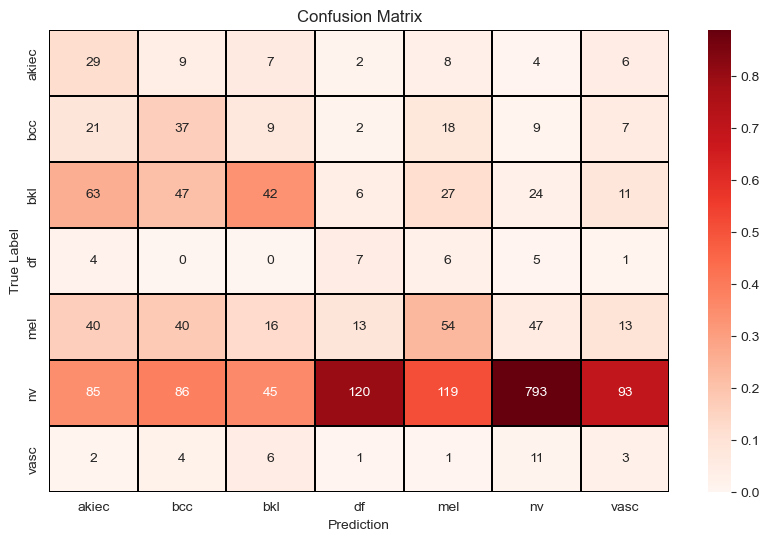

In [14]:
# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize XGB model
clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=7,
)

# Train model
clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=0, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_normalized, annot=cm, fmt=".0f", linewidths=.2, linecolor="black", xticklabels=class_labels,
                yticklabels=class_labels, cmap="Reds")
ax.set_xlabel("Prediction")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix")
plt.show()

Without oversampling --> guessed everything (~86% of predictions) as nv which resulted in 70% accuracy

### XGBoost Predictions used in Prototype

The output collected can be found in "predictions_xgboost.json"

In [15]:
def get_predictions(meta_df, clf, X_test, transformed_meta_df, age_lst=None):
    all_results = {}

    # Create metadata array
    samples_meta_df = meta_df.loc[X_test.index]
    sample_values = samples_meta_df.reset_index(drop=True).sample(n=1)

    # Create sample
    test_values = sample_values[transformed_meta_df.columns]

    # Find matching metadata row
    mask = (samples_meta_df == sample_values.values).all(axis=1)
    all_metadata = meta_df.loc[samples_meta_df[mask].index]

    # Get image
    image_id = all_metadata['image_id'].values
    all_results[image_id[0]] = {
        'true class': sample_values['dx'].values[0],
        'true sex': sample_values['sex'].values[0]
    }

    if age_lst:
        all_results.update(get_age_pred(all_results, clf, test_values, sample_values['age'].values[0], image_id))

        for i in age_lst:
            # Scale age variable
            age_variable = mm_scaler.transform(pd.DataFrame([[i]], columns=['age']))
            test_values['age_scaled'] = age_variable

            all_results.update(get_age_pred(all_results, clf, test_values, i, image_id))
    return all_results


def get_age_pred(all_results, clf, test_values, age, image_id):
    # Predict
    pred_label = clf.predict(test_values)
    pred_probs = clf.predict_proba(test_values)

    # Top classes
    top_classes = [f"{class_labels[i]}: {round(pred_probs[0][i]*100, 2)}" for i in np.argsort(pred_probs[0])[::-1]]

    all_results[image_id[0]][age] = {}
    all_results[image_id[0]][age]['predicted class'] = class_labels[pred_label[0]]
    all_results[image_id[0]][age]['predicted prob'] = round(max(pred_probs[0])*100, 2)
    all_results[image_id[0]][age]['top 3 predictions'] = top_classes[:3]

    all_results.update(get_sex_pred(all_results, clf, test_values, age, image_id))
    return all_results


def get_sex_pred(all_results, clf, test_values, age, image_id):
    # Opposite sex
    sex = test_values['sex_binary'].values[0]
    test_values_sex = test_values.copy()
    test_values_sex['sex_binary'] = 1 if sex == 0 else 0

    # Predict
    pred_label = clf.predict(test_values_sex)
    pred_probs = clf.predict_proba(test_values_sex)

    # Top classes
    top_classes = [f"{class_labels[i]}: {round(pred_probs[0][i]*100, 2)}" for i in np.argsort(pred_probs[0])[::-1]]

    all_results[image_id[0]][age]['opposite sex'] = {}
    all_results[image_id[0]][age]['opposite sex']['predicted class'] = class_labels[pred_label[0]]
    all_results[image_id[0]][age]['opposite sex']['predicted prob'] = round(max(pred_probs[0])*100, 2)
    all_results[image_id[0]][age]['opposite sex']['top 3 predictions'] = top_classes[:3]

    return all_results

In [16]:
run = False

if run:
    ages = [10, 40, 80]
    predictions = get_predictions(meta_df, clf, X_test, transformed_meta_df, ages)

    # with open("content/predictions.json", "w") as f:
    #     json.dump(data, f, indent=4)

    with open("content/predictions.json", "a") as f:
         json.dump(predictions, f, indent=4)

## Dataset Class

In [17]:
# Create lesion-level DataFrame
lesion_df = meta_df.groupby("lesion_id").first().reset_index()
lesion_df = lesion_df[["lesion_id", "dx"]]

# Stratified split: train 70%, temp 30%
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
train_idx, temp_idx = next(sss.split(lesion_df["lesion_id"], lesion_df["dx"]))
train_lesions = lesion_df.iloc[train_idx]["lesion_id"].values
temp_lesions = lesion_df.iloc[temp_idx]["lesion_id"].values

# Now split temp into val/test (stratified again)
temp_df = lesion_df.iloc[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_idx, test_idx = next(sss2.split(temp_df["lesion_id"], temp_df["dx"]))
val_lesions = temp_df.iloc[val_idx]["lesion_id"].values
test_lesions = temp_df.iloc[test_idx]["lesion_id"].values

# Assign full image metadata based on lesion_id
train_df = meta_df[meta_df["lesion_id"].isin(train_lesions)]
val_df = meta_df[meta_df["lesion_id"].isin(val_lesions)]
test_df = meta_df[meta_df["lesion_id"].isin(test_lesions)]

# Sample 1 image per lesion in val/test
val_df = val_df.groupby("lesion_id").sample(n=1, random_state=SEED).reset_index(drop=True)
test_df = test_df.groupby("lesion_id").sample(n=1, random_state=SEED).reset_index(drop=True)

In [18]:
class HAMDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = sorted(self.df["dx"].unique())
        self.label_to_idx = {lbl: idx for idx, lbl in enumerate(self.labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.label_to_idx[row["dx"]]
        if self.transform:
            image = self.transform(image)

        metadata = torch.cat((
            torch.tensor(row['age_scaled'], dtype=torch.float32).unsqueeze(0),
            torch.tensor(row['sex_binary'], dtype=torch.float32).unsqueeze(0),
            torch.tensor(row.filter(regex='^loc_').values.astype("float32"))
        ), dim=0)

        return image, metadata, label

In [19]:
def build_balanced_subset(df: pd.DataFrame):
    cap = 700  # Fixed cap for ALL classes
    balanced_frames = []
    for dx, grp in df.groupby("dx"):
        if len(grp) > cap:
            grp_balanced = grp.sample(cap, random_state=SEED)
        else:
            reps_needed = cap - len(grp)
            extra = grp.sample(reps_needed, replace=True, random_state=SEED)
            grp_balanced = pd.concat([grp, extra], ignore_index=True)
        balanced_frames.append(grp_balanced)
    return pd.concat(balanced_frames, ignore_index=True)

train_df = build_balanced_subset(train_df)

In [20]:
print("\nBalanced TRAIN subset distribution:")
print(train_df["dx"].value_counts())

print("\nVAL subset distribution:")
print(val_df["dx"].value_counts())

print("\nTEST subset distribution:")
print(test_df["dx"].value_counts())


Balanced TRAIN subset distribution:
dx
akiec    700
bcc      700
bkl      700
df       700
mel      700
nv       700
vasc     700
Name: count, dtype: int64

VAL subset distribution:
dx
nv       810
bkl      109
mel       92
bcc       49
akiec     34
vasc      15
df        11
Name: count, dtype: int64

TEST subset distribution:
dx
nv       811
bkl      109
mel       92
bcc       49
akiec     35
vasc      14
df        11
Name: count, dtype: int64


In [21]:
# Using computed normalization values from the first run
mean = torch.tensor([0.7581, 0.5716, 0.6016])
std = torch.tensor([0.0816, 0.1092, 0.1176])


In [22]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05)),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.05
    ),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [23]:
# Loading the data
train_dataset = HAMDataset(train_df, DATA_DIR, transform=train_tfms)
val_dataset = HAMDataset(val_df, DATA_DIR, transform=eval_tfms)
test_dataset = HAMDataset(test_df, DATA_DIR, transform=eval_tfms)  # NEW!

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          worker_init_fn=seed_worker,
                          generator=g)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True,
                        worker_init_fn=seed_worker,
                        generator=g)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         pin_memory=True,
                         worker_init_fn=seed_worker,
                         generator=g)

### Transform Metadata Values

In [24]:
# Create metadata tensor to be used
metadata_tensor = torch.tensor(transformed_meta_df.values, dtype=torch.float32)

In [25]:
def get_resnet34(num_classes):
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

## XGBoost Classifier on Image Feature Extraction

In [26]:
class FeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(FeatureExtractor, self).__init__()
        # Load pretrained image-only model
        image_model = get_resnet34(num_classes)
        image_model.load_state_dict(torch.load("content/model/best_resnet34.pt", weights_only=False))

        # Remove the final layer
        self.features = nn.Sequential(*list(image_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


feature_extractor = FeatureExtractor(len(class_labels))
feature_extractor.eval()
image_branch = feature_extractor.features.to(DEVICE)

In [27]:
def extract_features(loader, model, device, split_name):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, _, labels in tqdm(loader):
            images = images.to(device)
            features = model(images)  # outputs shape: (batch_size, 512, 1, 1)
            features = features.view(features.size(0), -1)  # shape: (batch_size, 512)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)

    torch.save({'features': X, 'labels': y}, os.path.join(SAVE_DIR, f"{split_name}_features.pt"))
    print("Saved")

In [28]:
# Extract features
if not os.path.exists(os.path.join(SAVE_DIR, "train_features.pt")):
    extract_features(train_loader, image_branch, DEVICE, "train")
    extract_features(val_loader, image_branch, DEVICE, "val")
    extract_features(test_loader, image_branch, DEVICE, "test")

In [29]:
# Load features
train_data = torch.load(os.path.join(SAVE_DIR, "train_features.pt"), weights_only=False)
X_train = train_data['features']
y_train = train_data['labels']

val_data = torch.load(os.path.join(SAVE_DIR, "val_features.pt"), weights_only=False)
X_val = val_data['features']
y_val = val_data['labels']

test_data = torch.load(os.path.join(SAVE_DIR, "test_features.pt"), weights_only=False)
X_test = test_data['features']
y_test = test_data['labels']

In [30]:
# Get the model
if os.path.exists(os.path.join(SAVE_DIR, "best_xgboost_on_feature.json")):
    clf = XGBClassifier(tree_method='hist')
    clf.load_model(os.path.join(SAVE_DIR, "best_xgboost_on_feature.json"))
else:
    # Train XGBoost
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_train, y_train)
    clf.save_model(os.path.join(SAVE_DIR, "best_xgboost_on_feature.json"))

              precision    recall  f1-score   support

       akiec       0.51      0.80      0.62        35
         bcc       0.71      0.85      0.77        48
         bkl       0.60      0.65      0.63       107
          df       0.62      0.91      0.74        11
         mel       0.37      0.80      0.50        91
          nv       0.99      0.79      0.88       783
        vasc       0.65      0.93      0.76        14

    accuracy                           0.78      1089
   macro avg       0.64      0.82      0.70      1089
weighted avg       0.86      0.78      0.81      1089



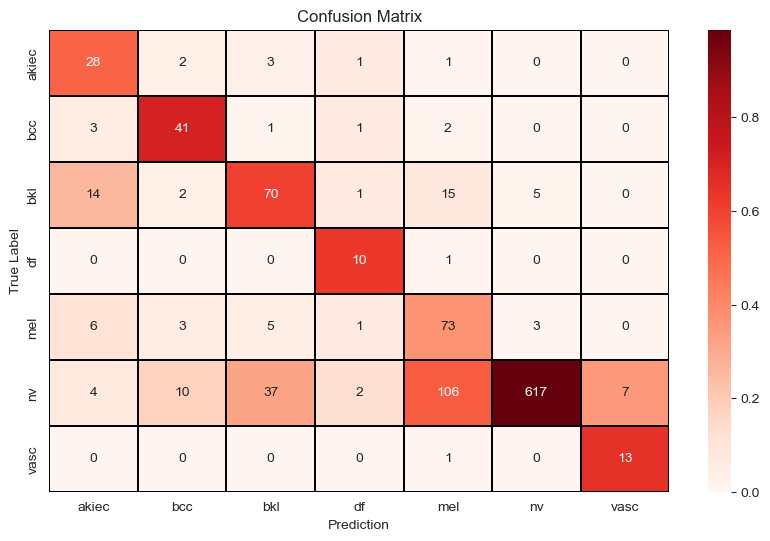

In [31]:
# Evaluate
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=0, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_normalized, annot=cm, fmt=".0f", linewidths=.2, linecolor="black", xticklabels=class_labels,
                yticklabels=class_labels, cmap="Reds")
ax.set_xlabel("Prediction")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix")
#plt.savefig(os.path.join("content/images/confusion_matrix_xgboost.png"))
plt.show()

## Hybrid ResNet34 Model

In [34]:
# Define the new hybrid model
class Hybrid(nn.Module):
    def __init__(self, metadata_input_dim, num_classes):
        super(Hybrid, self).__init__()

        # Load pretrained image-only model
        image_model = get_resnet34(num_classes)
        image_model.load_state_dict(torch.load("content/model/best_resnet34.pt", weights_only=True))

        # Remove the final layer
        image_feature_extractor = nn.Sequential(*list(image_model.children())[:-1])
        self.image_branch = image_feature_extractor

        # Freeze image branch
        for param in self.image_branch.parameters():
            param.requires_grad = False

        # Reduced image features
        self.reduce_image = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.2)
        )

        # Metadata branch
        self.metadata_branch = nn.Sequential(
            nn.Linear(metadata_input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=False),
            nn.Linear(32, 16),
            nn.ReLU(inplace=False)
        )

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 + 16, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, image, metadata):
        img_features = self.image_branch(image)
        img_features = img_features.view(img_features.size(0), -1)
        reduced_image = self.reduce_image(img_features)
        if metadata.dim() == 1:
            metadata = metadata.unsqueeze(1)
        metadata_features = self.metadata_branch(metadata)
        combined = torch.cat((reduced_image, metadata_features), dim=1)
        output = self.classifier(combined)
        return output

## Training

In [35]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [36]:
# Train and Eval Functions
scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0.0, 0
    for imgs, meta, labels in loader:
        imgs, meta,labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(imgs, meta)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0.0, 0
    with torch.no_grad():
        for imgs, meta, labels in loader:
            imgs, meta,labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs, meta)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

In [37]:
# Main training function
def run_training(model, model_name, train=train_loader, val=val_loader):
    optimizer = torch.optim.AdamW(list(model.metadata_branch.parameters()) + list(model.classifier.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    label_order = train_dataset.labels
    class_freq = train_df["dx"].value_counts().reindex(label_order)
    class_weights = 1.0 / class_freq
    weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(DEVICE)

    # Weighted + Label Smoothing loss to reduce overfitting tendency..
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
    early_stopper = EarlyStopping(patience=5, delta=0.001)

    best_val_acc = 0.0
    model.to(DEVICE)

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val, criterion)
        scheduler.step()
        # scheduler.step(val_acc)  # for ReduceLROnPlateau

        print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"best_{model_name}.pt"))
            print(f"  -> Best model saved!")

        early_stopper(val_acc)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break

    print(f"Finished {model_name} training with best Val Acc: {best_val_acc:.4f}")

In [38]:
hybrid_model = Hybrid(metadata_tensor.shape[1], len(class_labels))
hybrid_model.to(DEVICE)

# Run training and save best model
#run_training(hybrid_model, "efficient-hybrid", train_loader)

Hybrid(
  (image_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## Evaluation

In [39]:
def evaluate_model(model, loader, label_names, hybrid):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for imgs, metadata, labels in loader:
            if not hybrid:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
            else:
                imgs, metadata, labels = imgs.to(DEVICE), metadata.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs, metadata)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        target_names=label_names,
        digits=4,
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(cm_normalized, annot=cm, fmt=".0f", linewidths=.2, linecolor="black", xticklabels=label_names,
                    yticklabels=label_names, cmap="Reds")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix")
    #plt.savefig(os.path.join("content/images/confusion_matrix.png"))
    plt.show()


def load_and_evaluate(model_fn, model_name, path, loader, label_names, device=DEVICE, hybrid=False):
    model = model_fn
    model.load_state_dict(torch.load(path, weights_only=False))
    model.to(device)
    print(f"\n=== {model_name} Evaluation ===")
    report = evaluate_model(model, loader, label_names, hybrid)
    return model, report


--- VALIDATION SET EVALUATION ---

=== ResNet34-Hybrid VALIDATION Evaluation ===

Classification Report:
              precision    recall  f1-score   support

       akiec     0.5952    0.7353    0.6579        34
         bcc     0.6769    0.8980    0.7719        49
         bkl     0.6961    0.6514    0.6730       109
          df     0.5500    1.0000    0.7097        11
         mel     0.4632    0.6848    0.5526        92
          nv     0.9688    0.8827    0.9238       810
        vasc     0.8235    0.9333    0.8750        15

    accuracy                         0.8420      1120
   macro avg     0.6820    0.8265    0.7377      1120
weighted avg     0.8706    0.8420    0.8514      1120



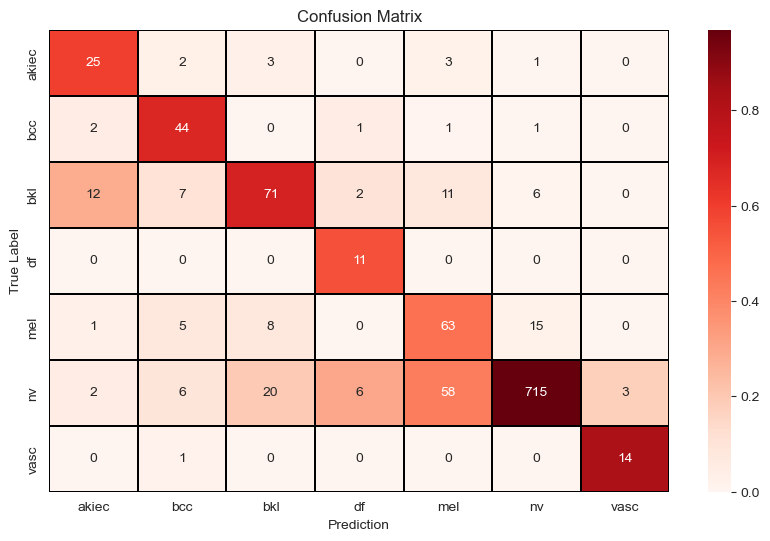



--- TEST SET EVALUATION ---
=== ResNet34-Hybrid TEST Evaluation ===

Classification Report:
              precision    recall  f1-score   support

       akiec     0.4717    0.7143    0.5682        35
         bcc     0.6418    0.8776    0.7414        49
         bkl     0.6577    0.6697    0.6636       109
          df     0.6429    0.8182    0.7200        11
         mel     0.4146    0.5543    0.4744        92
          nv     0.9619    0.8718    0.9146       811
        vasc     0.7778    1.0000    0.8750        14

    accuracy                         0.8225      1121
   macro avg     0.6526    0.7866    0.7082      1121
weighted avg     0.8527    0.8225    0.8333      1121



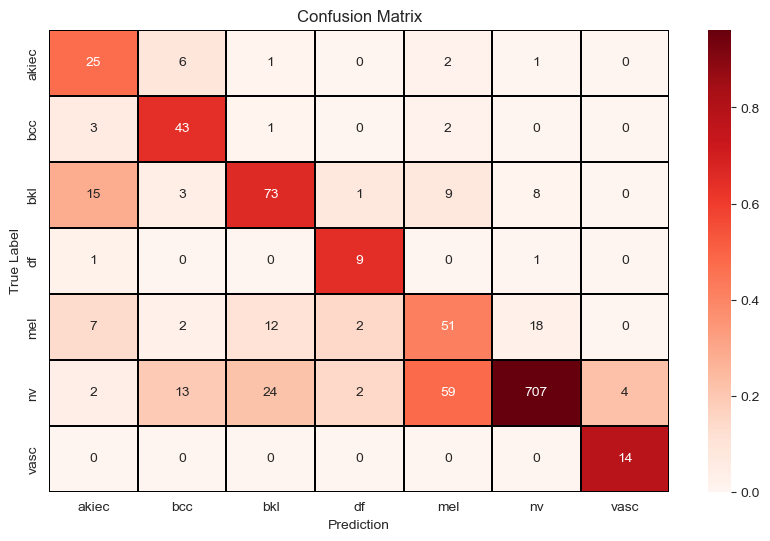

In [40]:
# === VALIDATION SET ===
print("\n--- VALIDATION SET EVALUATION ---")

# ResNet34 - Hybrid
model_resnet_hybrid, resnet_val_report = load_and_evaluate(
    Hybrid(metadata_tensor.shape[1], len(class_labels)),
    "ResNet34-Hybrid VALIDATION",
    os.path.join(SAVE_DIR, "best_resnet34-hybrid.pt"),
    val_loader,
    class_labels,
    hybrid=True
)

# === TEST SET ===
print("\n\n--- TEST SET EVALUATION ---")

# ResNet34 - Hybrid
print("=== ResNet34-Hybrid TEST Evaluation ===")
resnet_test_report = evaluate_model(model_resnet_hybrid, test_loader, class_labels, hybrid=True)

## Shap

In [41]:
class MetadataOnlyModel(nn.Module):
    def __init__(self, hybrid_model, fixed_image_features=None):
        super(MetadataOnlyModel, self).__init__()
        self.hybrid_model = hybrid_model
        self.fixed_image_features = fixed_image_features  # shape: (1, 512)

        if self.fixed_image_features is None:
            # Use zeros if no image data provided
            self.fixed_image_features = torch.zeros((1, 512))

    def forward(self, metadata):
        batch_size = metadata.size(0)
        # Repeat the fixed image features for batch
        img_features = self.fixed_image_features.repeat(batch_size, 1).to(metadata.device)
        if metadata.dim() == 1:
            metadata = metadata.unsqueeze(1)
        metadata_features = self.hybrid_model.metadata_branch(metadata)
        reduce_image = self.hybrid_model.reduce_image(img_features)
        combined = torch.cat((reduce_image, metadata_features), dim=1)
        output = self.hybrid_model.classifier(combined)
        return output


def summary_with_shap(model, loader, device=DEVICE):
    """Apply SHAP to the hybrid model and visualize results."""
    # Get background and test samples
    x = iter(loader)
    background_batch = next(x)
    test_batch = next(x)

    background_image, background_meta, background_label = background_batch
    test_image, test_meta, test_label = test_batch

    # Create a SHAP explainer
    model_wrapped = MetadataOnlyModel(model)
    model_wrapped.eval()
    model.eval()
    # Random test image from sample
    idx = random.randint(0, background_image.size(0) - 1)
    test_image = test_image[idx:idx+1]
    test_meta = test_meta[idx:idx+1]
    test_label = test_label[idx:idx+1]

    # Prediction (temp)
    test_image, test_meta = test_image.to(device), test_meta.to(device)
    with autocast(device_type='cuda'):
        out = model(test_image, test_meta)
    pred_class = out.argmax(dim=1).item()
    print(f"=== PREDICTION: {loader.dataset.labels[pred_class]} ===")

    # Get SHAP values
    explainer = shap.DeepExplainer(model_wrapped, background_meta.to(device))
    shap_values = explainer.shap_values(test_meta, check_additivity=False)


    return shap_values, explainer, (test_image.cpu(), test_meta.cpu().numpy(), test_label.cpu()), pred_class


def val_to_list(values, class_names):
    """Convert SHAP values to list of arrays"""
    shap_to_list = []
    for item in range(len(class_names)):
        shap_to_list.append(values[:,:,item])
    return shap_to_list


def plot_shap_summary(shap_values, data, mean, std, loader, explainer, transformed_meta_df, pred_class=None):
    """Visualize SHAP values for metadata."""
    image, metadata, label = data
    # Denormalize images for visualization
    mean_tensor = mean.clone().detach().view(3, 1, 1)
    std_tensor = std.clone().detach().view(3, 1, 1)

    # Denormalize image
    image = image.squeeze_(0)
    image = image * std_tensor + mean_tensor
    image = image.permute(1, 2, 0).cpu().numpy()

    # Plot image
    rc_file_defaults()
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"True Class: {loader.dataset.labels[label.item()]}, Predicted Class: {loader.dataset.labels[label.item()]}")
    plt.axis("off")
    #plt.savefig("content/images/shap_2.1.png", bbox_inches='tight')
    plt.show()

    # Get info about the metadata
    shap_list = val_to_list(shap_values, loader.dataset.labels)
    class_names = loader.dataset.labels
    features = transformed_meta_df.columns.to_list()

    # Get values to display along feature names
    age = [[int(i) for i in sub] for sub in mm_scaler.inverse_transform(metadata[0][0].reshape(1, -1))]
    attributes = np.concatenate((age, metadata[0][1:].reshape(1, -1)), axis=1)
    feature_names = [
        f"{a}: {b}" for a, b in zip(features, attributes[0])
    ]

    # Plot SHAP values for metadata
    print(f"\n=== SHAP SUMMARY VALUES FOR METADATA ON TARGET IMAGE ===")
    shap.summary_plot(shap_list, metadata, plot_type="bar", class_names=class_names,
                      feature_names=feature_names, show=False, plot_size=(9, 5))
    #plt.savefig("content/images/shap_2.2.png", bbox_inches='tight')
    plt.show()

    print(f"\n=== SHAP WATERFALL VALUES FOR METADATA ON TARGET IMAGE ===")
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0].T[label.item()],
        base_values=explainer.expected_value[label.item()],
        data=metadata[0],
        feature_names=features
    ), show=False)
    #plt.savefig("content/images/shap_2.3.png", bbox_inches='tight')
    plt.show()

In [42]:
# Get SHAP values
shap_values, explainer, data, pred_class = summary_with_shap(model_resnet_hybrid, test_loader)

=== PREDICTION: nv ===


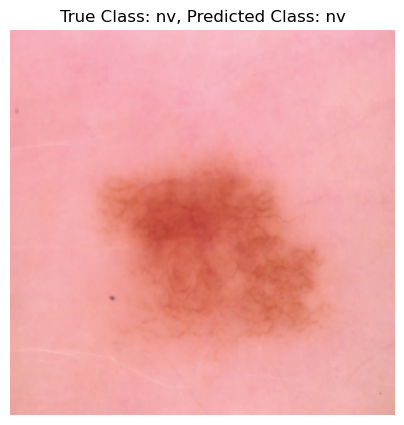


=== SHAP SUMMARY VALUES FOR METADATA ON TARGET IMAGE ===


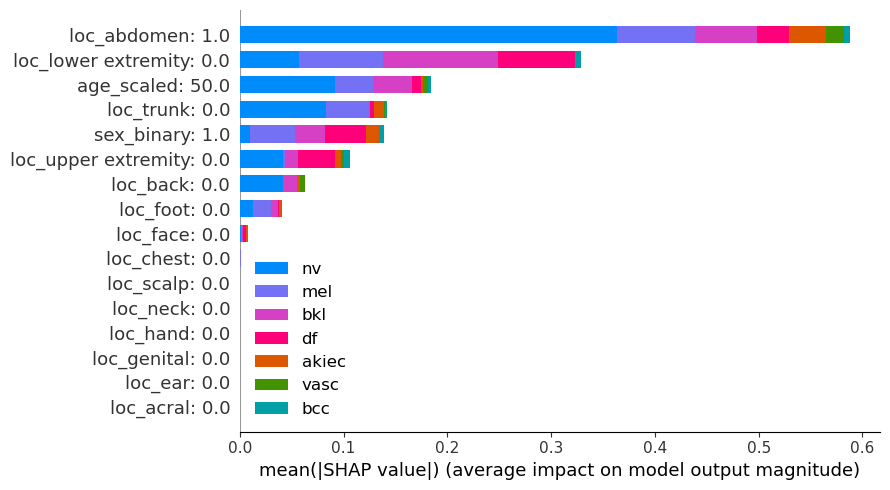


=== SHAP WATERFALL VALUES FOR METADATA ON TARGET IMAGE ===


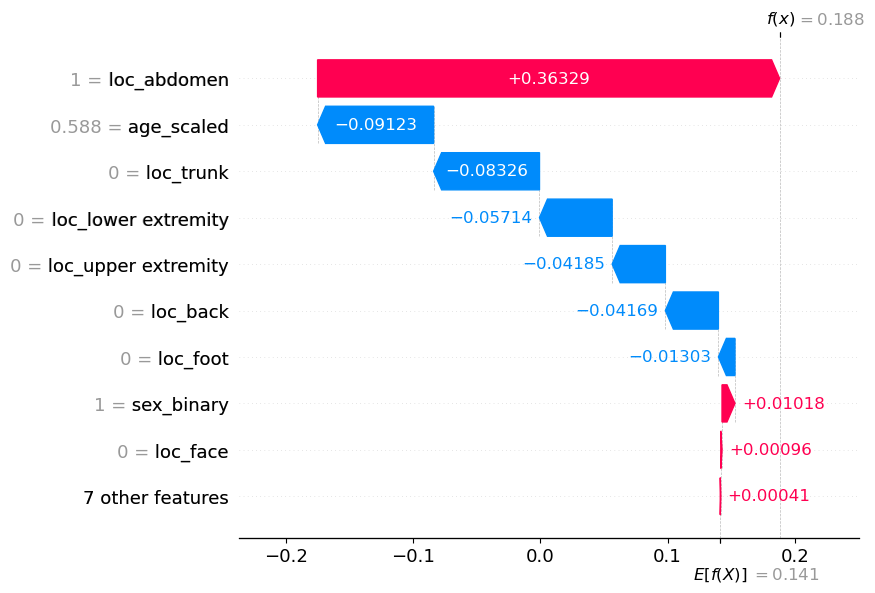

In [43]:
# Visualize SHAP summary values
plot_shap_summary(shap_values, data, mean, std, test_loader, explainer, transformed_meta_df)